In [1]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns
from scipy.stats import beta,binom,betabinom
import networkx as nx


## Parameters

In [2]:
#Datasets
dataDir="./datasets/"
datasets=[
    "adult",
    "airport",
    "flights",
    "food",
    "Hospital",
    "ncvoter",
    "SPStock",
    "tax500k",
]

In [3]:
#Algorithms
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [4]:
#Approximation factors to be used by algorithms
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]

In [5]:
#Approximation factors on false data for the figures
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))

# Code

## Dataset

In [6]:
class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types={col:typeMap[match[2]] for col,match in zip(self.columns,self.header)}
        
        self.df=pd.read_csv(file,**args,dtype=self.types)
        for i,col in enumerate(self.columns):
            self.df[col]=self.df[col].astype(self.types[col])
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
        self.PLILen={col:np.array([len(self.PLI[col][v])for v in self.PLI[col]]) for col in self.df}
        self.vals={col:np.array([v for v in self.PLI[col]]) for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

## DenialConstraintResult

In [7]:
class Operator:
    def __init__(self,func,expFunc,smpFunc=None) -> None:
        self.func=func
        self.expFunc=expFunc
        self.smpFunc=smpFunc
        self.neg=None
        self.imp=None
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return revopmap[self]
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    n=sum(l)**2
    return np.sum(l**2)/n

def eqSmp(vals,PLI,PLILen):
    prob=PLILen**2
    prob=prob/prob.sum()
    while True:
        v=np.random.choice(vals,10000,replace=True,p=prob)
        for vl in v:
            vl=PLI[vl]
            i,j=np.random.randint(0,len(vl),size=2)
            yield vl[i],vl[j]

       

eq=Operator(operator.eq,eqExp,eqSmp)

def neExp(l,r):
    n=sum(l)
    return 1-np.sum(l**2)/n**2
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq))/n**2
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq+l))/n**2
le=Operator(operator.le,leExp)

def gtExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq-l))/n**2
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq))/n**2
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}

opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
revopmap={y:x for x,y in opmap.items()}

eq.neg=ne
ne.neg=eq
gt.neg=le
le.neg=gt
lt.neg=ge
ge.neg=lt

eq.imp=[ge,le,eq]
ne.imp=[ne]
gt.imp=[gt,ge,ne]
lt.imp=[lt,le,ne]
ge.imp=[ge]
le.imp=[le]


class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
    def eval(self,df,t0,t1):
        return self.op(t0[self.l],t1[self.r])
    def expected(self,df):
        if self.exp is None:
            self.exp=self.op.expected(df.PLILen[self.l],None)
        return self.exp
    def sample(self,df):
        if self.op.smpFunc is not None:
            return self.op.smpFunc(df.vals[self.l],df.PLI[self.l],df.PLILen[self.l])
        else:
            return self.defSmp(df)
           
    def defSmp(self,df):
        while(True):
            v=np.random.choice(len(df.df),(10000,2),replace=True)
            t0s=df.df.loc[v[:,0],[self.l]].reset_index()
            t1s=df.df.loc[v[:,1],[self.r]].reset_index()
            res=self.eval(df,t0s,t1s)
            for (i,j),r in zip(v,res):
                if r:
                    yield (i,j)

            
    
    def __repr__(self) -> str:
        return 't0.'+self.l +' '+self.op.__repr__()+' t1.'+self.r+''
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
    def eval(self,df,t0,t1):
        return sum([pred.eval(df,t0,t1) for pred in self.preds])
    def coverage(self,df,t0s,t1s):
        pos,neg=0,0
        num=self.eval(df,t0s,t1s)
        dclen=len(self.preds)
        pos=(num==dclen).sum()
        neg=(num<dclen).sum()

                
        return neg/(pos+neg)
    def sampleCoverage(self,df,n=None):
        nn=len(df.df)
        if n is None:
            n=nn**2
        t0s = np.random.randint(0,len(df.df),n)
        t1s = np.random.randint(0,len(df.df),n)
        t1s=(t1s+(t1s==t0s)*np.random.randint(1,len(df.df),n))%len(df.df)
        return self.coverage(df,df.df.loc[t0s].reset_index(),df.df.loc[t1s].reset_index())
    def expCoverage(self,df):
        return 1-np.prod([pred.expected(df) for pred in self.preds])
    def __repr__(self) -> str:
        return "¬("+" ^ ".join([pred.__repr__() for pred in self.preds])+")"


class DenialConstraintSet:
    def __init__(self,path,dataset,algorithm) -> None:        
        self.predicates={}
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            if (c1,c2,op) not in self.predicates:
                self.predicates[(c1,c2,op)]=Predicate(c1,opmap[op],c2)
            return self.predicates[(c1,c2,op)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred).groups()) for pred in preds]
                self.DCs.append(DenialConstraint(preds))


# Result generation

## Discover DCs

Runs all algorithms and stores discovered DCs.

In [ ]:
#Run all algorithms. Takes a long time. You may instead extract the file results20k.zip, containing the precomputed results.
i=0
start=1
for dataset in datasets[-1:]:
    for algorithm in algorithms:
        for aprox in ["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]:
            i+=1
            if i<start:
                continue
            print(f"---------------ITERATION: {i}")
            print("RUN: {}_{}_{}".format(algorithm,dataset,aprox))
            command='java -Xmx12g -jar {} {} {} 20000'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox)
            result = subprocess.run(command, shell=True)
            print("MOVE: {}_{}_{}".format(algorithm,dataset,aprox))
            command='mv output.txt results/{}_{}_{}'.format(algorithm,dataset,aprox)
            result = subprocess.run(command, shell=True)



## Compute satisfaction on false data

Compute satisfaction proportion on false data for all DCs accepted on true data.

In [103]:
#load datasets
dss={}
for dataset in datasets:
    print(dataset)
    dss[dataset]=Dataset(dataDir+dataset+".csv",nrows=20000,encoding='unicode_escape')
    dss[dataset].buildPLIs()

adult
airport
flights
food
Hospital
ncvoter
SPStock
tax500k


In [ ]:
#Compute satisfaction of accepted DCs on shuffled data. Takes a long time. You may instead execute the cell two steps below to load the precomputed results.
results={}
for algorithm in algorithms[:]:
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
    for aprox in aproxs:
        for dataset in datasets:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,algorithm)
            n=1000000
            
            t0s=dss[dataset].randFields(n)
            t1s=dss[dataset].randFields(n)
            res=[]
            for dc in dcs.DCs:
                sup=dc.coverage(dcs,t0s,t1s)
                res.append(sup)
            results[(algorithm,dataset,aprox)]=res


In [ ]:
#Save results so they can be used later.
with open("results/DCSups.json", 'w') as json_file:
        json.dump(results, json_file, indent=4)

In [ ]:
#Load results so they dont need to be computed.
with open("results/DCSups.json") as f:
    results=json.load(f)

## Plot triviality

Generate LaTeX code for the plots showing how all accepted DCs are also accepted after shuffling the data.

In [ ]:
#Generate dataframe with the false data satisfaction for each combination of dataset, algorithm and approx.factor
algDf={}
DCsups={}
for algorithm in algorithms[:]:
    dfs=[]
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
    sups=np.array(supports)
    for aprox in aproxs:
        df={}
        for dataset in datasets:
            key="_".join([algorithm,dataset,aprox])
            res=results[key]
            

            counts=np.zeros_like(sups)
            for sup in res:
                sup=sup
                counts+=1-sup<=sups
            DCsups[key]=counts/len(res)
            counts[1:]=counts[1:]-counts[:-1]

            
            
            df[dataset]=counts/counts.sum()
        dfs.append(pd.DataFrame(df,index=[sups]).transpose())
    algDf[algorithm]=dfs

In [ ]:
#Color according to if satisfaction on false data is greater or equal thant on true data. These are definitely trivial.
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))
width=13
height=2
yspace=0.3
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+=tikzLegend(width+1.25,-(height +yspace)*(len(algorithms)-1) - height)
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+height/4})--({x+width},{y+height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+2*height/4})--({x+width},{y+2*height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+3*height/4})--({x+width},{y+3*height/4});\n"
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node[rotate=-90] at ({x+width+0.25},{y+height/2}) {{ \\small {algorithms[a]} }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y}) {{ \\tiny 0\\% }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y+height}) {{ \\tiny 100\\% }};\n"

    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    if a in [4]:
        res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/5 * (t-5//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height-1e-2}) rectangle ({x+barwidth},{y0+sup[s]*height+1e-2});\n"
        ss=s
        y=sup[s]
    if a in [4]:
        res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{s/len(supports)*0.8 + 0.1},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))-1e-2}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))+1e-2});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.5)--(13,-1.5);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.0)--(13,-1.0);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-0.5)--(13,-0.5);
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (0.3044444444444445,-2.01) rectangle (0.47444444444444456,0.00633699633699635);
\definecolor{mycolor}{hsb}{0.1,1,1};
\fill[mycolor] (1.7488888888888887,-2.01) rectangle (1.9188888888888886,-0.6566666666666667);
\definecolor{mycolor}{hsb}{0.5003996003996004,1,1};
\fill[mycolor] (1.7488888888888887,-0.6766666666666667) rectangle (1.9188888888888886,-0.4185714285714286);
\definecolor{mycolor}{hsb}{0.6450549450549451,1,1};
\fill[mycolor] (1.7488888888888887,-0.4385714285714286) rectangle (1.9188888888888886,-0.3709523809523809);
\definecolor{mycolor}{hsb}{0.6474525474525474,1,1};
\fill[mycolor] (1.7488888888888887,-0.39095238095238094) rectangle (1.9188888888888886,-0.32333333333333325);
\definecolor{mycolor}{hsb}{0.6922077922077923,1,1};


In [ ]:
#Color according to satisfaction on false data to show how, even if satisfaction on false data is not higher than on true data, it is extremely close.
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))
width=13
height=2
yspace=0.3
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+height/4})--({x+width},{y+height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+2*height/4})--({x+width},{y+2*height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+3*height/4})--({x+width},{y+3*height/4});\n" 
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node[rotate=-90] at ({x+width+0.25},{y+height/2}) {{ \\small {algorithms[a]} }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y}) {{ \\tiny 0\\% }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y+height}) {{ \\tiny 100\\% }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    if a in [4]:
        res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/5 * (t-5//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height-1e-2}) rectangle ({x+barwidth},{y0+sup[s]*height+1e-2});\n"
        ss=s
        y=sup[s]
    if a in [4]:
        res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))-1e-2}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))+1e-2});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.5)--(13,-1.5);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.0)--(13,-1.0);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-0.5)--(13,-0.5);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (0.3044444444444445,-2.01) rectangle (0.47444444444444456,0.00633699633699635);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-2.01) rectangle (1.9188888888888886,-0.6566666666666667);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (1.7488888888888887,-0.6766666666666667) rectangle (1.9188888888888886,-0.4185714285714286);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (1.7488888888888887,-0.4385714285714286) rectangle (1.9188888888888886,-0.3709523809523809);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fill[mycolor] (1.7488888888888887,-0.39095238095238094) rectangle (1.9188888888888886,-0.32333333333333325);
\definecolor{mycolor}{hsb}{0.3333333333333333,1,1};
\fil

In [ ]:
#Color DCs according to if we have a minimal evidence their satisfaction on true data is not due to triviality.
supbase=np.linspace(-8,0,1000)
supports=np.array([0]+list(np.power(10,supbase)))
width=13
height=2
yspace=0.3
xspace=0.2
barwidth=0.17

legendwidth=0.5

def tikzFigure(DCsups):
    res=""
    res+="\\begin{tikzpicture}\n"
    res+="".join(tikzAlgorithm(a) for a in range(len(algorithms)))
    res+="\\end{tikzpicture}\n"
    return res
def tikzAlgorithm(a):
    x=0
    y=-(height +yspace)*a - height
    res=""
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+height/4})--({x+width},{y+height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+2*height/4})--({x+width},{y+2*height/4});\n"
    res+=f"\\draw[draw=gray,opacity=0.5,ultra thin] ({x},{y+3*height/4})--({x+width},{y+3*height/4});\n"
    res+="".join(tikzDataset(a,d,x,y) for d in range(len(datasets)))
    res+=f"\\draw ({x},{y}) rectangle ++({width},{height});\n"
    res+=f"\\node[rotate=-90] at ({x+width+0.25},{y+height/2}) {{ \\small {algorithms[a]} }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y}) {{ \\tiny 0\\% }};\n"
    res+=f"\\node[anchor=east] at ({x-0.02},{y+height}) {{ \\tiny 100\\% }};\n"
    return res

def tikzDataset(a,d,x0,y0):
    x=x0+width/len(datasets)*(d+0.5) 

    res=""
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    res+="".join(tikzThreshold(a,d,t,x,y0) for t in range(len(aproxs)))
    if a in [4]:
        res+=f"\\node at ({x},{y0-1}) {{ \\small {datasets[d]} }};\n"
    return res

def tikzThreshold(a,d,t,x0,y0):
    aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithms[a] not in ['Hydra','FastDC'] else ["0.00"]
    x=x0 +(width/len(datasets)-2*xspace)/5 * (t-5//2)
    key="_".join([algorithms[a],datasets[d],aproxs[t]])
    sup=DCsups[key]
    res=""
    y=0
    for s in range(len(supports)):
        h=sup[s]-y
        if h<0.01:
            continue        
        n=10000**2
        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if binom.cdf(float(aproxs[t])*n,n,1-supports[s])<= 0.1 else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x},{y0+y*height-1e-2}) rectangle ({x+barwidth},{y0+sup[s]*height+1e-2});\n"
        ss=s
        y=sup[s]
    if a in [4]:
        res+=f"\\node[anchor=west,rotate=-90] at ({x+0.085},{y0-0.02}) {{ \\tiny ${aproxexp[t]}$ }};\n"

    return res

def tikzLegend(x0,y0):
    res=""
    
    for s in range(1,len(supports)):

        res+=f"\\definecolor{{mycolor}}{{hsb}}{{{0 if supports[s]<=float(aproxs[t]) else 1/3},1,1}};\n"
        res+=f"\\fill[mycolor] ({x0},{y0*(1-(s-1)/(len(supports)-1))-1e-2}) rectangle ({x0+legendwidth},{y0*(1-s/(len(supports)-1))+1e-2});\n"

    ticks=np.array(list(np.round(np.linspace(supbase[0],supbase[-1],5))))
    for s,b in enumerate(ticks):
        res+=f"\\node[align=left] at ({x0-0.3},{y0*(1-s/(len(ticks)-1))}) {{ \\tiny $10^{{{int(b)}}}$ }};\n"

    res+=f"\\draw ({x0},{y0}) rectangle ({x0+legendwidth},{0});\n"
    return res
print(tikzFigure(DCsups))


\begin{tikzpicture}
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.5)--(13,-1.5);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-1.0)--(13,-1.0);
\draw[draw=gray,opacity=0.5,ultra thin] (0,-0.5)--(13,-0.5);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (0.3044444444444445,-2.01) rectangle (0.47444444444444456,0.00633699633699635);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-2.01) rectangle (1.9188888888888886,-0.6566666666666667);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-0.6766666666666667) rectangle (1.9188888888888886,-0.4185714285714286);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-0.4385714285714286) rectangle (1.9188888888888886,-0.3709523809523809);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-0.39095238095238094) rectangle (1.9188888888888886,-0.32333333333333325);
\definecolor{mycolor}{hsb}{0,1,1};
\fill[mycolor] (1.7488888888888887,-0.34333333333333327) rectangle (1.91

## Plot decision thresholds for random DCs

Generate random DCs of size 2 and 3 and plot their satisfaction to show how it is very easy to assemble random predicates and het highly satisfied nonsensical DCs.

In [ ]:
#Function to enumerate all possible DCs of a certain size or less.
def enumerateDCs(df,n,size=3):
    predicates={}
    def getPred(c1,c2,op):
        if (c1,c2,op) not in predicates:
            predicates[(c1,c2,op)]=Predicate(c1,op,c2)
        return predicates[(c1,c2,op)]
    for s in range(2,size+1):
        for cols in itertools.combinations(df.df.columns,s):

            validOps=[[eq,ne,gt,lt] if df.df[col].dtype==float else [eq,ne]   for col in cols]

            for ops in itertools.product(*validOps):
                dc= DenialConstraint([getPred(c,c,op) for op,c in zip(ops,cols)])   
                yield (dc.expCoverage(df),dc.sampleCoverage(df,n),dc)

In [ ]:
#For each random DC, get its expected satisfaction under independence of predicates assumption and its actual satisfaction
from scipy.stats import binom, beta
dcs=[]
sSupp=[]
eSupp=[]
rSupp=[]
dset=[]
stat=[]

for i,dataset in enumerate(datasets[-1:]):
    df=dss[dataset]
    n=1000000
    res=list(enumerateDCs(df,n,size=3))
    sSupp+=[x[1] for x in res]
    eSupp+=[x[0] for x in res]
    rSupp+=[(x[1]-x[0])/(1-x[0]) for x in res]
    dset+=[i for _ in res]
    dcs+=[x[-1] for x in res]

    stat+=[binom.cdf(n-n*x[1],n,(1-x[0])) for x in res]

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs')

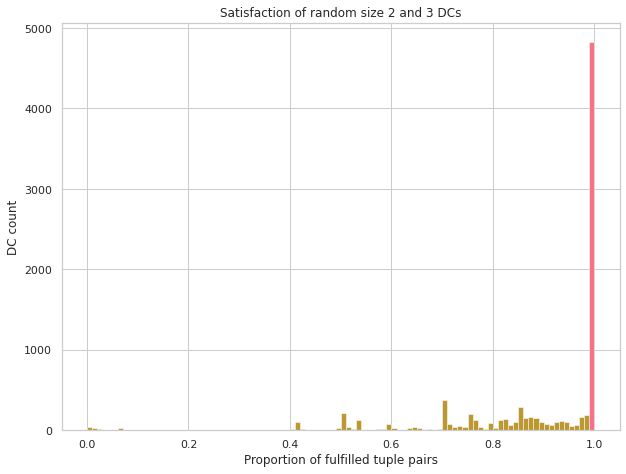

In [ ]:
#Histogram of satisfactions
sns.set_theme(style="whitegrid", palette="husl")
plt.figure(figsize=(20/2,15/2))
sns.histplot(x=sSupp,bins=100,hue=[s<0.99 for s in sSupp],alpha=1,legend=False)
plt.xlabel("Proportion of fulfilled tuple pairs")
plt.ylabel("DC count")
plt.title("Satisfaction of random size 2 and 3 DCs")

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs')

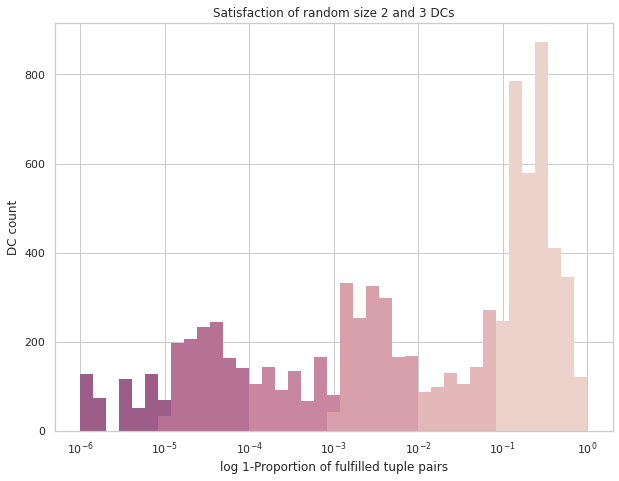

In [ ]:
#Plot satisfactions very close to 100% not reaching it to show again how easy it is and why approximation leads to accepting random DCs
sns.set_theme(style="whitegrid", palette="husl")
plt.figure(figsize=(20/2,15/2))
sns.histplot(x=1-np.array(sSupp),bins=np.logspace(-6,0,40),hue=-np.floor(np.log(np.maximum(1e-10,1-np.array(sSupp)))/np.log(10)) ,alpha=1,legend=False)
plt.xlabel("log 1-Proportion of fulfilled tuple pairs")
plt.ylabel("DC count")
plt.xscale("log")
plt.title("Satisfaction of random size 2 and 3 DCs")

In [ ]:
#Print some examples for the document.
[(dc,s) for dc,s,ds in zip(dcs,sSupp,dset) if s>0.99 and s< 0.999 and datasets[ds]=='tax500k']

[(!["LName(String)" ne "LName(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.99094),
 (!["LName(String)" ne "LName(String)" & "Phone(String)" eq "Phone(String)"],
  0.99308),
 (!["Gender(String)" eq "Gender(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.99583),
 (!["Gender(String)" ne "Gender(String)" & "AreaCode(String)" eq "AreaCode(String)"],
  0.9957),
 (!["Gender(String)" eq "Gender(String)" & "Phone(String)" eq "Phone(String)"],
  0.99701),
 (!["Gender(String)" ne "Gender(String)" & "Phone(String)" eq "Phone(String)"],
  0.99637),
 (!["Gender(String)" eq "Gender(String)" & "State(String)" eq "State(String)"],
  0.99045),
 (!["Gender(String)" ne "Gender(String)" & "State(String)" eq "State(String)"],
  0.99012),
 (!["AreaCode(String)" eq "AreaCode(String)" & "Phone(String)" ne "Phone(String)"],
  0.99125),
 (!["AreaCode(String)" ne "AreaCode(String)" & "Phone(String)" eq "Phone(String)"],
  0.99336),
 (!["AreaCode(String)" eq "AreaCode(String)" & "City(String

Text(0.5, 1.0, 'Satisfaction of random size 2 and 3 DCs on true and false data')

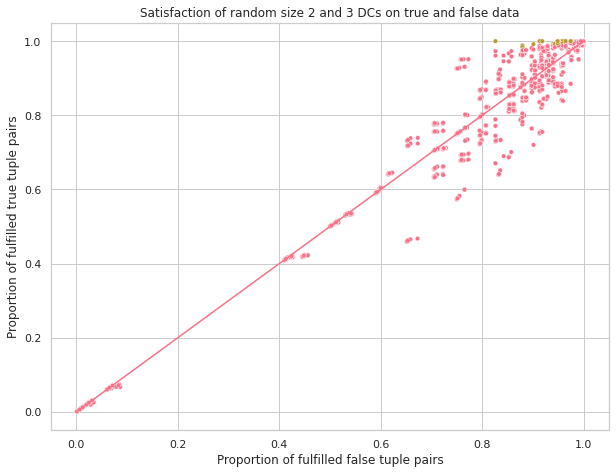

In [ ]:
#Instead of accepting by satisfaction, show how we may pick ones with high satisfaction and low satisfaction on false data.
sns.set_theme(style="whitegrid", palette="husl")
plt.figure(figsize=(20/2,15/2))
y=1-(1-np.array(sSupp))
x=1-(1-np.array(eSupp))
c=[es<0.98 and (ss-es)/(1-es)>0.85 for s,ss,es in zip(stat,sSupp,eSupp)]
sns.scatterplot(y=y,x=x,hue=c,alpha=1,legend=False,s=20)
sns.lineplot(x=[1e-5,1],y=[1e-5,1])
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("Proportion of fulfilled false tuple pairs")
plt.ylabel("Proportion of fulfilled true tuple pairs")
plt.title("Satisfaction of random size 2 and 3 DCs on true and false data")

In [ ]:
#Show some examples
for k in [(dc,s,e) for dc,cc,s,e,ds in zip(dcs,c,sSupp,eSupp,dset) if cc]:
    print(str(k))

## Predicate probabilities

Section to get predicate probabilities and such. For the tables showing predicate and DC probabilities.

In [ ]:
ds=Dataset("datasets/tax500k.csv")
ds.buildPLIs()

In [ ]:
dc=DenialConstraint([Predicate("Zip(String)",eq,"Zip(String)")])
1-dc.expCoverage(ds)

4.731997727969173e-05

In [ ]:
dc=DenialConstraint([Predicate("LName(String)",eq,"LName(String)")])
1-dc.expCoverage(ds)

0.00010199118796438977

In [ ]:
dc=DenialConstraint([Predicate("AreaCode(String)",eq,"AreaCode(String)")])
1-dc.expCoverage(ds)

0.008888308693199232

In [ ]:
dc=DenialConstraint([Predicate("Gender(String)",eq,"Gender(String)")])
1-dc.expCoverage(ds)

0.5000086278925115

In [ ]:
dc=DenialConstraint([Predicate("State(String)",eq,"State(String)"),Predicate("Salary(Integer)",lt,"Salary(Integer)"),Predicate("Rate(Double)",gt,"Rate(Double)")])
dc.expCoverage(dss['tax500k'])
dc.sampleCoverage(dss['tax500k'],100000)
dc in [DenialConstraint([Predicate("State(String)",eq,"State(String)"),Predicate("Salary(Integer)",lt,"Salary(Integer)"),Predicate("Rate(Double)",gt,"Rate(Double)")])]

False

In [ ]:
cols=ds.df.columns[[1,3,4,7,8,9,10,12]]
cols

Index(['LName(String)', 'AreaCode(String)', 'Phone(String)', 'Zip(String)',
       'MaritalStatus(String)', 'HasChild(String)', 'Salary(Integer)',
       'SingleExemp(Integer)'],
      dtype='object')

In [ ]:
ops=[eq,eq,eq,eq,ne,ne,eq,ne]
res=1
for col,op in zip(cols,ops):
    dc=DenialConstraint([Predicate(col,op,col)])
    val=1-dc.expCoverage(ds)
    res*=val
    print(val)
print(res)

0.00010199118796438977
0.008888308693199232
0.0002587584070325999
4.731997727969173e-05
0.49999533652334616
0.499995433739735
0.0050017980671722695
0.5879416090040843
8.160431409227706e-18


## Algorithm

Section for the algorithm to discover DCs using new triviality.

In [8]:
ds=Dataset("datasets/tax500k.csv")
#ds=Dataset("datasets/airport.csv")
ds.buildPLIs()

In [71]:
from collections import deque
trivAlpha=0.0001
satAlpha=0.01

class PredSet:
    def __init__(self,preds,predID) -> None:
        self.predID=predID
        self.preds=preds
    
    def __hash__(self) -> int:
        return hash(self.predID)
    def __eq__(self, value: object) -> bool:
        return self.predID==value.predID
    def root():
        return PredSet(set(),0)
    def single(p):
        return PredSet({p},1<<p)
    def multi(preds):
        id=0
        for p in preds:
            id|=1<<p
        return PredSet({p for p in preds},id)
    def child(self,p):
        return self|PredSet.single(p)
    def __or__(self,other):
        return PredSet(self.preds|other.preds,self.predID|other.predID)
    def __sub__(self,other):
        return PredSet(self.preds-other.preds,self.predID&(~other.predID))
    def __repr__(self) -> str:
        return "{"+ ",".join([str(x) for x in self.preds])+"}"
    def __contains__(self,p):
        return p in self.preds
    def __le__(self,other):
        return (self.predID&(~other.predID))==0
    def __ge__(self,other):
        return (other.predID&(~self.predID))==0
    
    def __len__(self):
        return len(self.preds)
    

    def itTree(self):
        queue=deque([self])
        visited=set()
        while len(queue)>0:
            ps=queue.popleft()
            yield ps
            if len(ps.preds)>0:
                for p in ps.preds:
                    pss=ps-PredSet.single(p)
                    if pss not in visited:
                        visited.add(pss)
                        queue.append(pss)
                

class Edge:
    def __init__(self,f,t,pred,prob):
        #Graph connections
        self.f:Node=f
        self.t:Node=t
        self.pred=pred

        #Evi counters
        self.pos=0
        self.tot=0
        self.trivPval=1
        self.satPval=1

        self.prob=prob

        #List links
        self.trivPrev=None
        self.trivNext=None

    def __repr__(self) -> str:
        return self.f.__repr__()+"->"+str(self.f.g.preds[self.pred])
    def filterEvi(self,evi,li):
        return li[evi[li,self.pred]]

    def getEvi(self):
        evi,li=self.f.getEvi()
        fli=self.filterEvi(evi,li)
        return evi,fli


    def calcPval(self):
        #Triviality:
        #X|ABCD... must be different than all X|A,X|AB,X|ABC...
        #All must be impossible statistically, largest pval must be small
        #If source is root, always nontrivial
        if len(self.f.predSet)==0:
            self.trivPval=0
        else:
            #Otherwise, check every subset to see if it explains behaviour of new variable
            #If all p-values are low, we have evidence behaviour is not explained by any subset
            self.trivPval=-1
            for ps in self.f.predSet.itTree():
                if len(ps)==len(self.f.predSet):
                    continue#Skip first
                if ps not in self.f.g.g.nodes:
                    self.trivPval=-1
                    break
                n=self.f.g.g.nodes[ps]['node']

                if self.pred not in n.edges:
                    self.trivPval=-1
                    break
                e=n.edges[self.pred]
                trivPval=min(betabinom.cdf(self.pos,n=self.tot,a=e.pos+1,b=e.tot-e.pos+1),betabinom.cdf(self.tot-self.pos,n=self.tot,a=e.tot-e.pos+1,b=e.pos+1))
                self.trivPval=max(trivPval,self.trivPval)
            if self.trivPval<0:
                self.trivPval=1
    def pushEvi(self,evi,li):
        

        fli=self.filterEvi(evi,li)
        self.tot+=li.shape[0]
        self.pos+=fli.shape[0]

        self.calcPval()


        if fli.shape[0]>100:
            self.t.pushEvi(evi,fli)

    def getRatio(self):
        return np.log(self.pos)-np.log(self.tot)-np.log(self.prob)
        

class Node:
    def __init__(self,g,predSet,predID,colSet,prob):
        self.g:Graph=g
        #Information about node predicates
        self.predSet=PredSet(predSet,predID)
        self.colSet=colSet

        self.prob=prob
    
        #Edges
        self.edges={}
        self.source=None
        self.supersets={}
        self.subsets={}
        
    def __hash__(self) -> int:
        return hash(self.predSet)
    def __eq__(self, other: object) -> bool:

        if isinstance(other, Node):
            return self.predSet == other.predSet
        return False

    def __repr__(self) -> str:
        return "{"+",".join([str(self.g.preds[p]) for p in self.predSet.preds ])+"}"
    
    def pushEvi(self,evi,li):
        if li.shape[0]==0:
            return

        for n,e in self.edges.items():
            e.pushEvi(evi,li)
    def getEvi(self):
        if self.predSet.predID==0:
            return self.g.rootEvi,np.arange(0,len(self.g.rootTPs))
        else:
            return self.source.getEvi()
    def getRes(self):

        res=[]
        if self.source is not None:
            if self.source.satPval>0.1 and self.source.trivPval<trivAlpha and self.source.tot>50:
                res.append(self)
        for _,e in self.edges.items():
            res=res+e.t.getRes()
        return res



class Graph:
    def __init__(self,ds:Dataset):
        self.ds=ds
        self.root=Node(self,set(),0,set(),1)
        
        self.buildPredicates(ds)
        self.rootEvi=np.zeros((0,len(self.preds)),dtype=bool)
        self.rootTPs=set()

        #list
        self.head=None

        #graph
        self.g=nx.DiGraph()
        self.g.add_node(self.root.predSet,node=self.root)


    def buildPredicates(self,ds:Dataset):
        self.preds=[]
        self.predCol=[]
        
        for ci,col in enumerate(ds.columns):
            validOps=[eq,ne,gt,lt] if ds.df[col].dtype==float else [eq,ne]
            for op in validOps:
                pred=Predicate(col,op,col)
                self.preds.append(pred)
                self.predCol.append(ci)
                

    def createChild(self,n:Node,p):
        predProb=self.preds[p].expected(self.ds)
        newPS=n.predSet|PredSet.single(p)
        if newPS in self.g.nodes:
            nn=self.g.nodes[newPS]['node']
        else:
            nn=Node(self,newPS.preds,newPS.predID,n.colSet|{self.predCol[p]},n.prob*predProb)
            self.g.add_node(nn.predSet,node=nn)
        e=Edge(n,nn,p,predProb)
        n.edges[p]=e

        #add to list
        self.queueEdge(e)

        

        #Add sub/super set edges



        return nn
    def queueEdge(self,e:Edge):
        if self.head is not None:
            self.head.trivPrev=e
            e.trivNext=self.head
        self.head=e
    def unqueueEdge(self,e:Edge):
        if e.trivPrev is not None:
            e.trivPrev.trivNext=e.trivNext
        else:
            self.head=e.trivNext
        if e.trivNext is not None:
            e.trivNext.trivPrev=e.trivPrev


    def expandNode(self,n:Node):
        for i,pred in enumerate(self.preds):
            if self.predCol[i] not in n.colSet:                
                self.createChild(n,i)
    
    def sort(self):

        def cmp(l:Edge,r:Edge):
            if l.trivPval != r.trivPval:
                return l.trivPval<=r.trivPval
            if l.satPval != r.satPval:
                return l.satPval<=r.satPval
            
            return len(l.f.predSet) <= len(r.f.predSet)
        def swap(l:Edge,r:Edge):
            l.trivNext=r.trivNext
            if l.trivNext is not None:
                l.trivNext.trivPrev=l
            
            r.trivPrev=l.trivPrev
            if r.trivPrev is not None:
                r.trivPrev.trivNext=r
            l.trivPrev=r
            r.trivNext=l
            if self.head==l:
                self.head=r

        change=True

        while change:
            #print(len(list(self.itEdges())))
            change=False
            n=self.head
            while n.trivNext is not None:
                nn=n.trivNext

                if not cmp(n,nn):
                    swap(n,nn) 
                    change=True
                n=nn

    def expandSome(self):

        e=self.head
        r=None
        while e is not None and r is None:
            if e.trivPval<trivAlpha and e.satPval <satAlpha and e.t.source is None:
                r=e
            e=e.trivNext 
        return r
        
    
    def expandSomeNode(self,r:Edge):
        self.unqueueEdge(r)
        
        r.t.source=r
        #sync evidence
        evi,li=r.t.getEvi()
        self.expandNode(r.t)
        if li.shape[0]>0:
            r.t.pushEvi(evi,li)
        print(f"Expand: {r} {r.trivPval} {r.satPval}")
            
    
    def sampleRoot(self,ds:Dataset,n):
        rows=len(ds.df)
        curLen=len(self.rootTPs)

        #Expand memory if necessary
        if curLen+n>self.rootEvi.shape[0]:
            newLen=curLen+n
            newLen=newLen+newLen//2
            newEvi=np.zeros((newLen,len(self.preds)),dtype=bool)
            newEvi[:curLen,:]=self.rootEvi[:curLen,:]
            self.rootEvi=newEvi
        #Sample
        def tryTP():
            i,=np.random.randint(0,rows,size=1)
            j,=np.random.randint(0,rows-1,size=1)
            if j>=i:
                j=(j+1)%rows
            return (i,j)
        tpi=[]
        tpj=[]
        for _ in range(n):            
            tp=tryTP()
            while tp in self.rootTPs:
                tp=tryTP()
            self.rootTPs.add(tp)
            tpi.append(tp[0])
            tpj.append(tp[1])

        t0s=ds.df.loc[tpi].reset_index()
        t1s=ds.df.loc[tpj].reset_index()
        evi=np.zeros((n,len(self.preds)),dtype=bool)
        for i,pred in enumerate(self.preds):
            pred:Predicate=pred
            evi[:,i]=pred.eval(ds,t0s,t1s)
        
        self.rootEvi[curLen:curLen+n,:]=evi
        return self.rootEvi,np.arange(curLen,curLen+n)
    
    def trace(self,n):
        if n.source is None:
            return
        e=n.source
        print(f"{e.f} -> {e.t}: {e.tot} {e.pos} {e.prob} | {e.satPval} {e.trivPval}")
        self.trace(e.f)
    def itEdges(self):
        x=self.head
        while x is not None:
            yield x
            x=x.trivNext

    def getRes(self):
        for e in self.itEdges():
            if e.tot>50 and e.trivPval<trivAlpha and e.satPval>0.1 and e.t.source is None and e.pos==0:
                yield e
    
    def itLevel(self):
        level=0
        nextNodes=set([self.root])        
        while len(nextNodes)>0:
            level+=1
            nodes=nextNodes
            nextNodes=set()

            for n in nodes:
                yield level,n
                for p in n.edges:
                    nextNodes.add(n.edges[p].t)

    def itPreorder(self,f,n=None):
        if n is None:
            n=self.root
        f(n)
        for nn,e in n.edges.items():
            if nn.source==e:
                self.itPreorder(f,nn)






In [192]:
class PredGraph:
    class PredSet:
        def __init__(self,preds,predID) -> None:
            self.predID=predID
            self.preds=preds
        
        def __hash__(self) -> int:
            return hash(self.predID)
        def __eq__(self, value: object) -> bool:
            return self.predID==value.predID
        def root():
            return PredGraph.PredSet(set(),0)
        def single(p):
            return PredGraph.PredSet({p},1<<p)
        def multi(preds):
            id=0
            for p in preds:
                id|=1<<p
            return PredGraph.PredSet({p for p in preds},id)
        def child(self,p):
            return self|PredGraph.PredSet.single(p)
        def __or__(self,other):
            return PredGraph.PredSet(self.preds|other.preds,self.predID|other.predID)
        def __sub__(self,other):
            return PredGraph.PredSet(self.preds-other.preds,self.predID&(~other.predID))
        def __repr__(self) -> str:
            return "{"+ ",".join([str(x) for x in self.preds])+"}"
        def __contains__(self,p):
            return p in self.preds
        def __le__(self,other):
            return (self.predID&(~other.predID))==0
        def __ge__(self,other):
            return (other.predID&(~self.predID))==0
        
        def __len__(self):
            return len(self.preds)
        
    class Node:
        def __init__(self,ps) -> None:
            self.ps:PredGraph.PredSet=ps
            self.sup={}
            self.sub={}
            self.node=None

    def __init__(self) -> None:
        self.root=PredGraph.Node(PredGraph.PredSet.root())
        self.nodes={self.root.ps:self.root}
    def hasChild(self,n,p):
        n:PredGraph.Node=n
        ps=PredGraph.PredSet.single(p)
        pss=ps|n.ps
        return pss in self.nodes
    def getChild(self,n,p):
        n:PredGraph.Node=n
        ps=PredGraph.PredSet.single(p)
        pss=ps|n.ps
        return self.nodes[pss]
    def addChild(self,n,p):
        n:PredGraph.Node=n
        ps=PredGraph.PredSet.single(p)
        pss=ps|n.ps
        if pss not in self.nodes:
            nn=PredGraph.Node(pss)
            self.nodes[pss]=nn
        else:
            print("already in")
    def delChild(self,n,p):
        n:PredGraph.Node=n
        ps=PredGraph.PredSet.single(p)
        pss=ps|n.ps
        del self.nodes[pss]

    
    def iterSubsets(self,n):
        for ps,nn in self.nodes.items():
            if ps<=n.ps:
                yield nn
    def iterSupersets(self,n):
        for ps,nn in self.nodes.items():
            if ps>=n.ps:
                yield nn



class Algorithm:

    class Edge:
        def __init__(self,f,p) -> None:
            self.f:Algorithm.Node=f
            self.p:int=p
            self.t:Algorithm.Node=None
            self.n:int=0
            self.trivPVal=1
            self.maxTrivPVal=0
    class Node:
        def __init__(self,ps) -> None:
            self.ps:PredGraph.PredSet=ps
            self.f:Algorithm.Edge=None
            self.edges:dict=None

            self.sup:dict={}
            self.sub:dict={}

            self.satPVal=1
        def __hash__(self) -> int:
            return self.ps.__hash__()
        def __eq__(self, value: object) -> bool:
            return self.ps.__eq__(value.ps)
        def __repr__(self) -> str:
            return self.ps.__repr__()


    def __init__(self,ds,eps=0.0,trivAlpha=0.0000001,satAlpha=0.0000001,usedPreds=None) -> None:
        self.ds=ds
        self.eps=eps
        self.trivAlpha=trivAlpha
        self.satAlpha=satAlpha
        self.pg=PredGraph()
        



        self.buildPredicates(ds,usedPreds)
        self.rootEvi=np.zeros((0,len(self.preds)),dtype=bool)
        self.rootTPs=set()

        rootEdge=Algorithm.Edge(None,None)
        rootNode=Algorithm.Node(PredGraph.PredSet.root())
        rootEdge.t=rootNode
        rootNode.f=rootEdge
        self.pg.root.node=rootNode
        self.root=rootEdge
        self.cutNodes=set({rootNode})
        self.cutEdges=set({})

        
    def buildPredicates(self,ds:Dataset,usedPreds):
        self.preds=[]
        self.predCol=[]
        
        for ci,col in enumerate(ds.columns):
            validOps=[eq,ne,gt,lt,ge,le] if ds.df[col].dtype==float else [eq,ne]
            for op in validOps:
                pred=Predicate(col,op,col)
                self.preds.append(pred)
                self.predCol.append(ci)
        if usedPreds is not None:
            self.preds=[self.preds[i] for i in usedPreds]
            self.predCol=[self.predCol[i] for i in usedPreds]

    def sampleRoot(self,n):
        ds:Dataset=self.ds
        rows=len(ds.df)
        curLen=len(self.rootTPs)

        #Expand memory if necessary
        if curLen+n>self.rootEvi.shape[0]:
            newLen=curLen+n
            newLen=newLen+newLen//2
            newEvi=np.zeros((newLen,len(self.preds)),dtype=bool)
            newEvi[:curLen,:]=self.rootEvi[:curLen,:]
            self.rootEvi=newEvi
        #Sample
        def tryTP():
            i,=np.random.randint(0,rows,size=1)
            j,=np.random.randint(0,rows-1,size=1)
            if j>=i:
                j=(j+1)%rows
            return (i,j)
        tpi=[]
        tpj=[]
        for _ in range(n):            
            tp=tryTP()
            while tp in self.rootTPs:
                tp=tryTP()
            self.rootTPs.add(tp)
            tpi.append(tp[0])
            tpj.append(tp[1])

        t0s=ds.df.loc[tpi].reset_index()
        t1s=ds.df.loc[tpj].reset_index()
        evi=np.zeros((n,len(self.preds)),dtype=bool)
        for i,pred in enumerate(self.preds):
            pred:Predicate=pred
            evi[:,i]=pred.eval(ds,t0s,t1s)
        
        self.rootEvi[curLen:curLen+n,:]=evi
        return self.rootEvi,np.arange(curLen,curLen+n)

    def filterEvi(self,evi,li,p):
        return li[evi[li,p]]
    def expandNode(self,n):
        n:Algorithm.Node=n
        cols=set(self.predCol[p] for p in n.ps.preds)
        n.edges={}
        for p in self.preds:
            if self.predCol[p] not in cols:
                n.edges[p]=Algorithm.Edge(n,p)
    def propagateNode(self,n,evi,li,sync):
        n:Algorithm.Node=n
        
        if n.edges is not None:
            #Inner node, propagate evidence to edges
            for p,e in n.edges.items():
                self.propagateEdge(e,evi,li,sync)
                

    def getChild(self,n,p):
        n:Algorithm.Node=n
        if not self.pg.hasChild(n,p):
            self.pg.addChild(n,p)
        pn:PredGraph.Node=self.pg.getChild(n,p)
        nn=Algorithm.Node(pn.ps)
        pn.node=nn
        return nn



    def propagateEdge(self,e,evi,li,sync):
        e:Algorithm.Edge=e
        fli=self.filterEvi(evi,li,e.p) if e.f is not None else li
        e.n=fli.shape[0] if sync else fli.shape[0]+e.n

        if e.t is not None:
            #Inner edge, propagate evidence to node
            self.propagateNode(e.t,evi,fli,sync)

    def updateNodeSatisfaction(self,n):
        tot=len(self.rootTPs)
        pos=n.f.n
        #n.satPVal=betabinom.cdf(tot*self.eps,a=pos+1,b=tot-pos+1)
        n.satPVal=0 if tot>100 and pos>0 else 1

    def updateCut(self):
        
        cutEdges=list([n.edges[p] for n,p in self.cutEdges])

        for e in cutEdges:
            self.updateEdgeTriviality(e)
        for e in cutEdges:
            if e.trivPVal<self.trivAlpha:
                self.expandEdge(e)  
        cutNodes=list(self.cutNodes)
        for n in cutNodes:
            self.updateNodeSatisfaction(n)
        #Expand 
        for n in cutNodes:
            if n.satPVal<self.satAlpha:
                self.expandNode(n)
    
    def updateEdgeTriviality(self,e):
        e:Algorithm.Edge=e
        tot=e.f.f.n
        pos=e.n
        e.trivPVal=0 if e.f==self.root.t else 0

        for nn in self.pg.iterSubsets(e.f):
            #For every subset of n
            nn=nn.node
            if nn==e.f:
                continue
            #If it has an edge adding predicate of e
            if e.p not in nn.edges:
                continue
            ee=nn.edges[e.p]
            #If this edge has been proven nontrivial
            if ee.trivPVal > self.trivAlpha:
                continue

            #get one sided pvalue assuming both edges have the same distribution
            eetot=ee.f.f.n
            eepos=ee.n
            trivPVal=betabinom.cdf(pos,tot,a=eepos+1,b=eetot-eepos+1)
            #Get the maximum, as long as one edge explains this one it is trivial
            e.trivPVal=max(e.trivPVal,trivPVal)

    def expandNode(self,n):
        #Given node n, generate all edges spanning from it
        n:Algorithm.Node=n
        
        self.cutNodes.remove(n)

        colset=set({self.predCol[p] for p in n.ps.preds})
        n.edges={}
        for p,_ in enumerate(self.preds):
            c=self.predCol[p]
            if c not in colset:    
                e=Algorithm.Edge(n,p)
                n.edges[p]=e
                self.cutEdges.add((n,p))

    def expandEdge(self,e):
        e:Algorithm.Edge=e

        self.cutEdges.remove((e.f,e.p))

        nn=self.getChild(e.f,e.p)

        e.t=nn

        self.cutNodes.add(nn)          

        if e.f!=self.root.t:
            e.maxTrivPVal=max(e.trivPVal,e.f.f.maxTrivPVal)

        better=False
        if e.t.f==None:
            better=True
        elif e.t.f.maxTrivPVal>e.maxTrivPVal:  
            better=True
        
        if better:
            e.t.f=e

    def getDCs(self):

        cutNodes=sorted(list(self.cutNodes),key= lambda x:len(x.ps.preds))
        res=[]
        for n in cutNodes:
            minimal=True
            for nn in res:
                if n.ps<=nn.ps:
                    minimal=False
                    break
            
            if not minimal:
                continue
            res.append(n)

        return [DenialConstraint([self.preds[i] for i in n.ps.preds]) for n in res] 



In [231]:
usedPreds=[12,22,29]
a=Algorithm(dss['Hospital'],usedPreds=None)
a.expandNode(a.root.t)
evi,li=a.sampleRoot(20000)
a.propagateEdge(a.root,evi,li,True)
print(len(a.cutNodes),len(a.cutEdges))
a.updateCut()
print(len(a.cutNodes),len(a.cutEdges))
a.propagateEdge(a.root,evi,li,True)
a.updateCut()
print(len(a.cutNodes),len(a.cutEdges))
a.propagateEdge(a.root,evi,li,True)
a.updateCut()
print(len(a.cutNodes),len(a.cutEdges))
a.getDCs()

0 30
0 840
25 1882
27 1901


[¬(t0.Hospital Owner(String) <> t1.Hospital Owner(String) ^ t0.Phone Number(String) == t1.Phone Number(String)),
 ¬(t0.StateAvg(String) == t1.StateAvg(String) ^ t0.Condition(String) <> t1.Condition(String)),
 ¬(t0.Provider Number(String) == t1.Provider Number(String) ^ t0.Phone Number(String) <> t1.Phone Number(String)),
 ¬(t0.County Name(String) <> t1.County Name(String) ^ t0.Phone Number(String) == t1.Phone Number(String)),
 ¬(t0.Measure Name(String) <> t1.Measure Name(String) ^ t0.StateAvg(String) == t1.StateAvg(String)),
 ¬(t0.Provider Number(String) == t1.Provider Number(String) ^ t0.ZIP Code(String) <> t1.ZIP Code(String)),
 ¬(t0.ZIP Code(String) == t1.ZIP Code(String) ^ t0.County Name(String) <> t1.County Name(String)),
 ¬(t0.Measure Name(String) == t1.Measure Name(String) ^ t0.Condition(String) <> t1.Condition(String)),
 ¬(t0.StateAvg(String) == t1.StateAvg(String) ^ t0.State(String) <> t1.State(String)),
 ¬(t0.ZIP Code(String) == t1.ZIP Code(String) ^ t0.State(String) <> t1.St

In [239]:
n=list(a.cutNodes)[1]
n

{28,21}

In [243]:
n.f.f

{28}

In [233]:
list(enumerate(a.preds))

[(0, t0.Provider Number(String) == t1.Provider Number(String)),
 (1, t0.Provider Number(String) <> t1.Provider Number(String)),
 (2, t0.Hospital Name(String) == t1.Hospital Name(String)),
 (3, t0.Hospital Name(String) <> t1.Hospital Name(String)),
 (4, t0.City(String) == t1.City(String)),
 (5, t0.City(String) <> t1.City(String)),
 (6, t0.State(String) == t1.State(String)),
 (7, t0.State(String) <> t1.State(String)),
 (8, t0.ZIP Code(String) == t1.ZIP Code(String)),
 (9, t0.ZIP Code(String) <> t1.ZIP Code(String)),
 (10, t0.County Name(String) == t1.County Name(String)),
 (11, t0.County Name(String) <> t1.County Name(String)),
 (12, t0.Phone Number(String) == t1.Phone Number(String)),
 (13, t0.Phone Number(String) <> t1.Phone Number(String)),
 (14, t0.Hospital Type(String) == t1.Hospital Type(String)),
 (15, t0.Hospital Type(String) <> t1.Hospital Type(String)),
 (16, t0.Hospital Owner(String) == t1.Hospital Owner(String)),
 (17, t0.Hospital Owner(String) <> t1.Hospital Owner(String)),


In [175]:
ps=PredGraph.PredSet.multi([12,22,29])
a.pg.nodes[ps].node.f

In [176]:
ps=PredGraph.PredSet.multi([12,29])
a.pg.nodes[ps].node.edges
a.updateNodeSatisfaction(a.pg.nodes[ps].node)
a.updateCut()

AttributeError: 'NoneType' object has no attribute 'n'

In [207]:

for dataset in datasets:
    for algorithm in ["ours"]:
        for aprox in ["0.00"]:


            a=Algorithm(dss[dataset],usedPreds=None)
            a.expandNode(a.root.t)
            evi,li=a.sampleRoot(1000000)
            a.propagateEdge(a.root,evi,li,True)
            print(len(a.cutNodes),len(a.cutEdges))
            a.updateCut()
            print(len(a.cutNodes),len(a.cutEdges))
            a.propagateEdge(a.root,evi,li,True)
            a.updateCut()
            print(len(a.cutNodes),len(a.cutEdges))
            a.propagateEdge(a.root,evi,li,True)
            a.updateCut()
            print(len(a.cutNodes),len(a.cutEdges))
            dcs=a.getDCs()

            file='results/{}_{}_{}'.format(algorithm,dataset,aprox)

            with open(file,'w') as f:
                for dc in dcs:
                    f.write(dc.__repr__()+"\n")

0 54
0 2664
6 18013
6 39415
0 22
2 400
3 1191
3 1728
0 88
6 6788
121 53995
174 120688
0 44
6 1532
20 3908
20 5758
0 30
0 840
31 3391
33 4124
0 38
4 1176
10 2765
10 3365
0 34
0 968
1 2800
1 5984
0 50
0 2280
7 10734
63 28885


In [229]:
dss['Hospital'].df.head()

,Provider Number(String),Hospital Name(String),City(String),State(String),ZIP Code(String),County Name(String),Phone Number(String),Hospital Type(String),Hospital Owner(String),Emergency Service(String),Condition(String),Measure Code(String),Measure Name(String),Sample(String),StateAvg(String)
0,10018,CALLAHAN EYE FOUNDATION HOSPITAL,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Surgical Infection Prevention,SCIP-CARD-2,surgery patients who were taking heart drugs c...,nan,AL_SCIP-CARD-2
1,10018,CALLAHAN EYE FOUNDATION HOSPITAL,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Surgical Infection Prevention,SCIP-INF-1,surgery patients who were given an antibiotic ...,nan,AL_SCIP-INF-1
2,10018,CALLAHAN EYE FOUNDATION HOSPITAL,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Surgical Infection Prevention,SCIP-INF-2,surgery patients who were given the right kin...,nan,AL_SCIP-INF-2
3,10018,CALLAHAN EYE FOUNDATION HOSPITAL,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Surgical Infection Prevention,SCIP-INF-3,surgery patients whose preventive antibiotics ...,nan,AL_SCIP-INF-3
4,10018,CALLAHAN EYE FOUNDATION HOSPITAL,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Surgical Infection Prevention,SCIP-INF-4,all heart surgery patients whose blood sugar (...,nan,AL_SCIP-INF-4


In [230]:
dss['Hospital'].df.nunique()

Provider Number(String)      810
Hospital Name(String)        802
City(String)                 565
State(String)                 11
ZIP Code(String)             733
County Name(String)          254
Phone Number(String)         808
Hospital Type(String)          4
Hospital Owner(String)         9
Emergency Service(String)      2
Condition(String)              5
Measure Code(String)          28
Measure Name(String)          28
Sample(String)               885
StateAvg(String)             300
dtype: int64

In [56]:
g=Graph(ds)

In [17]:
evi,li=g.sampleRoot(ds,20000)

In [18]:
r=g.root.pushEvi(evi,li)
r

In [19]:
g.sort()

AttributeError: 'NoneType' object has no attribute 'trivNext'

In [20]:
for r in g.itEdges():
    print(f"{r} {r.trivPval} {r.satPval}")

In [21]:
while True:  
    e=g.expandSome()
    if e is None:
        break
    if len(e.f.predSet)>2:
        break  
    g.expandSomeNode(e)
    g.sort()

In [22]:
(([(e,e.tot,e.pos,e.prob,e.satPval,e.trivPval) for e in g.itEdges()]))

[]

In [23]:
r=list(g.getRes())
r

[]

In [ ]:
g.trace(r[0])

IndexError: list index out of range

In [ ]:
k=4
g.singlePreds[k].source.tot,g.singlePreds[k].source.pos,g.singlePreds[k].prob,g.singlePreds[k].source.pval,

(100000, 50069, 0.5000086278925115, 0.6678919159291299)

In [ ]:
g.preds[4],g.preds[14],g.preds[6],

("Gender(String)" eq "Gender(String)",
 "Zip(String)" eq "Zip(String)",
 "AreaCode(String)" eq "AreaCode(String)")

In [ ]:
evi.shape,len(g.rootTPs)

((29340, 40), 19560)

## Evidence necessary to prove two probabilities different

In [15]:
def binSearch(p,s,a,b,e,ee):

    mid=(b+e)/2
    n=np.exp(mid)
    pval=binom.cdf(s*n,n=n,p=p)

    stop=e-b<0.1
    if pval>a:
        return binSearch(p,s,a,mid,e,ee) if not stop else ee

    else:
        r = binSearch(p,s,a,b,mid,ee) if not stop else n
        return min(r,n)


In [20]:
binSearch(0.00001,0,0.05,0,100,np.exp(10))

310669.329091527

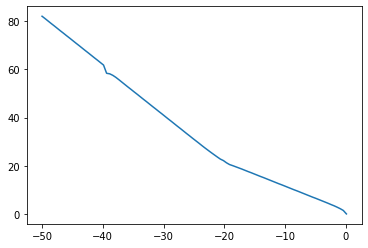

In [56]:
from matplotlib import pyplot as plt
s=0.000000001
x=np.linspace(0.1,-50,100)
y=[np.log(binSearch(s+np.exp(xx)*(1-s),s,0.01,0,150,np.exp(150))) for xx in x]
plt.plot(x,y)

In [46]:
[np.log(binSearch(s+np.exp(xx)*(1-s),0,0.01,0,100,np.exp(100))) for xx in x[-1:]]

[6.15234375]

## Trivial paths

Show how nontrivial nodes can be reached through nontrivial edges efficiently.

In [72]:
g=Graph(ds)

In [73]:
evi,li=g.sampleRoot(ds,100000)
ml=0
levelnodes=[]
for l,nn in g.itLevel():
    if l>ml:
        ml=l
        g.root.pushEvi(evi,li)
        for n in levelnodes:
              

            for e in n.edges:

                newMaxPVal=0 if n==g.root else max(n.maxPval,n.edges[e].trivPval)
                if n.edges[e].t.source is None:
                    n.edges[e].t.source=n.edges[e]
                    n.edges[e].t.maxPval=newMaxPVal
                    
                elif n.edges[e].t.maxPval>newMaxPVal:
                    n.edges[e].t.source=n.edges[e]
                    n.edges[e].t.maxPval=newMaxPVal
        levelnodes=[]
        print(l)
    if l<4:
        g.expandNode(nn)   
        levelnodes.append(nn)     


1
2
3
4


In [35]:
list(enumerate(g.preds))

[(0, "FName(String)" eq "FName(String)"),
 (1, "FName(String)" ne "FName(String)"),
 (2, "LName(String)" eq "LName(String)"),
 (3, "LName(String)" ne "LName(String)"),
 (4, "Gender(String)" eq "Gender(String)"),
 (5, "Gender(String)" ne "Gender(String)"),
 (6, "AreaCode(String)" eq "AreaCode(String)"),
 (7, "AreaCode(String)" ne "AreaCode(String)"),
 (8, "Phone(String)" eq "Phone(String)"),
 (9, "Phone(String)" ne "Phone(String)"),
 (10, "City(String)" eq "City(String)"),
 (11, "City(String)" ne "City(String)"),
 (12, "State(String)" eq "State(String)"),
 (13, "State(String)" ne "State(String)"),
 (14, "Zip(String)" eq "Zip(String)"),
 (15, "Zip(String)" ne "Zip(String)"),
 (16, "MaritalStatus(String)" eq "MaritalStatus(String)"),
 (17, "MaritalStatus(String)" ne "MaritalStatus(String)"),
 (18, "HasChild(String)" eq "HasChild(String)"),
 (19, "HasChild(String)" ne "HasChild(String)"),
 (20, "Salary(Integer)" eq "Salary(Integer)"),
 (21, "Salary(Integer)" ne "Salary(Integer)"),
 (22, "S

In [74]:
g.g.nodes[PredSet.multi([12,22,27])]['node'].source.pos

0

In [75]:
for l,n in g.itLevel():
    n:Node=n
    if l>2:
        if n.maxPval<0.0001 and n.source.pos==0:
            print(n)

{"State(String)" ne "State(String)","AreaCode(String)" eq "AreaCode(String)"}
{"MarriedExemp(Integer)" gt "MarriedExemp(Integer)","SingleExemp(Integer)" gt "SingleExemp(Integer)"}
{"MarriedExemp(Integer)" lt "MarriedExemp(Integer)","SingleExemp(Integer)" lt "SingleExemp(Integer)"}
{"Rate(Double)" lt "Rate(Double)","Salary(Integer)" gt "Salary(Integer)","AreaCode(String)" eq "AreaCode(String)"}
{"Rate(Double)" gt "Rate(Double)","State(String)" eq "State(String)","Salary(Integer)" lt "Salary(Integer)"}
{"MaritalStatus(String)" eq "MaritalStatus(String)","MarriedExemp(Integer)" gt "MarriedExemp(Integer)","AreaCode(String)" eq "AreaCode(String)"}
{"MaritalStatus(String)" eq "MaritalStatus(String)","MarriedExemp(Integer)" lt "MarriedExemp(Integer)","AreaCode(String)" eq "AreaCode(String)"}
{"MaritalStatus(String)" eq "MaritalStatus(String)","MarriedExemp(Integer)" gt "MarriedExemp(Integer)","SingleExemp(Integer)" ne "SingleExemp(Integer)"}
{"MaritalStatus(String)" eq "MaritalStatus(String)"

<AxesSubplot:>

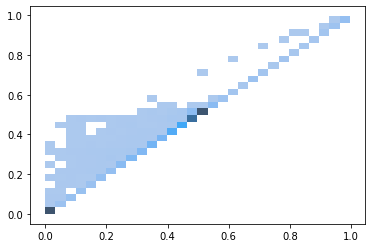

In [65]:
#Relationship between minimum pvalue in the path and p value of the node
x=[]
y=[]
for l,n in g.itLevel():
    if l>2:
        #print(str(n)+" "+str(n.source.tot)+" "+str(n.source.pos)+" "+str(n.source.prob)+" "+str(n.source.trivPval)+" "+str(n.maxPval))
        if n.source.tot<100:
            continue
        x.append(n.source.trivPval)
        y.append(n.maxPval)
#sns.histplot(x=np.maximum(-10,np.log(x)),y=np.maximum(-10,np.log(y)),pthresh=0.0,pmax=0.8,bins=30)
sns.histplot(x=x,y=y,bins=30)

/tmp/ipykernel_900/2528635358.py:12: RuntimeWarning: divide by zero encountered in log
  sns.histplot(x=np.maximum(-30,np.log(y)),pthresh=0.0,pmax=1,bins=50)


<AxesSubplot:ylabel='Count'>

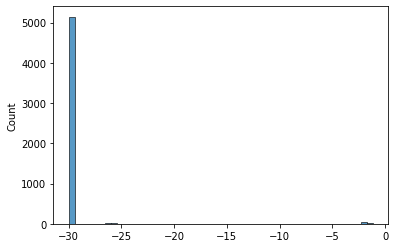

In [66]:
#Histogram of p value of most trivial edge in path for each non trivial node
x=[]
y=[]
r=[]
for l,n in g.itLevel():
    if l>2:
        #print(str(n)+" "+str(n.source.tot)+" "+str(n.source.pos)+" "+str(n.source.prob)+" "+str(n.source.trivPval)+" "+str(n.maxPval))
        if n.source.trivPval<1e-15 :
            y.append(n.maxPval)
            if n.maxPval>=0.01:
                r.append(n)
sns.histplot(x=np.maximum(-30,np.log(y)),pthresh=0.0,pmax=1,bins=50)

<AxesSubplot:ylabel='Count'>

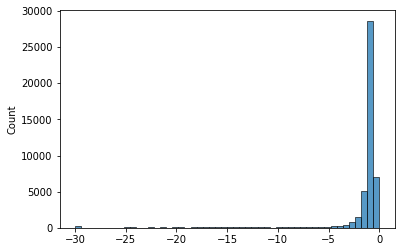

In [68]:
#Histogram of p value of most trivial edge in path for each trivial node
x=[]
y=[]
r=[]
for l,n in g.itLevel():
    if l>2:
        #print(str(n)+" "+str(n.source.tot)+" "+str(n.source.pos)+" "+str(n.source.prob)+" "+str(n.source.trivPval)+" "+str(n.maxPval))
        if n.source.trivPval>1e-15 :
            y.append(n.maxPval)
            if n.maxPval>=0.01:
                r.append(n)
sns.histplot(x=np.maximum(-30,np.log(y)),pthresh=0.0,pmax=1,bins=50)

## Efficacy plots

Plot precision and recall.

In [43]:

def algAproxDatasetNoise(alg,aprox,dataset,noise):
    v=(np.random.rand(1)[0]*0.2)if noise else 1
    if alg=='ours':
        v=1-(np.random.rand(1)[0]*0.1)
    return f"${v:0.2f}$" 

def algAproxDataset(alg,aprox,dataset):
    return algAproxDatasetNoise(alg,aprox,dataset,False)+"&"+algAproxDatasetNoise(alg,aprox,dataset,True)
def algAprox(alg,aprox):
    res=""
    res+=f"& ${aprox}$"
    for ds in datasets:
        res+="&"
        res+=algAproxDataset(alg,aprox,ds)
    return res
def alg(alg):
    res=""

    aproxexps=aproxexp if alg not in algorithms[:2] else ["0"]
    for i,aprox in enumerate(aproxexps):
        if i==0:
            res+=f"\multirow{{{len(aproxexps)}}}*{{{alg}}}"
        else:
            res+=f""
        res+=algAprox(alg,aprox)

        if i+1==len(aproxexps):
            res+=f"\\\\ \hline \n"
        else:
            res+=f"\\\\ \cline{{3-18}} \n"

    return res

def table():
    res=""
    for a in algorithms+['ours']:
        res+=alg(a)
        res+="\n"
    return res

print(table())

\multirow{1}*{FastDC}& $0$&$1.00$&$0.16$&$1.00$&$0.05$&$1.00$&$0.07$&$1.00$&$0.13$&$1.00$&$0.07$&$1.00$&$0.02$&$1.00$&$0.16$&$1.00$&$0.18$\\ \hline 

\multirow{1}*{Hydra}& $0$&$1.00$&$0.11$&$1.00$&$0.06$&$1.00$&$0.01$&$1.00$&$0.06$&$1.00$&$0.11$&$1.00$&$0.04$&$1.00$&$0.19$&$1.00$&$0.16$\\ \hline 

\multirow{5}*{DCFinder}& $0$&$1.00$&$0.05$&$1.00$&$0.11$&$1.00$&$0.05$&$1.00$&$0.16$&$1.00$&$0.07$&$1.00$&$0.10$&$1.00$&$0.09$&$1.00$&$0.05$\\ \cline{3-18} 
& $10^{-8}$&$1.00$&$0.20$&$1.00$&$0.12$&$1.00$&$0.16$&$1.00$&$0.18$&$1.00$&$0.03$&$1.00$&$0.05$&$1.00$&$0.14$&$1.00$&$0.02$\\ \cline{3-18} 
& $10^{-6}$&$1.00$&$0.03$&$1.00$&$0.11$&$1.00$&$0.03$&$1.00$&$0.00$&$1.00$&$0.09$&$1.00$&$0.15$&$1.00$&$0.02$&$1.00$&$0.03$\\ \cline{3-18} 
& $10^{-4}$&$1.00$&$0.09$&$1.00$&$0.19$&$1.00$&$0.16$&$1.00$&$0.00$&$1.00$&$0.10$&$1.00$&$0.09$&$1.00$&$0.12$&$1.00$&$0.15$\\ \cline{3-18} 
& $10^{-2}$&$1.00$&$0.02$&$1.00$&$0.03$&$1.00$&$0.17$&$1.00$&$0.00$&$1.00$&$0.16$&$1.00$&$0.19$&$1.00$&$0.06$&$1.00$&$0.03$\

In [41]:

def algAproxDatasetNoise(alg,aprox,dataset,noise):
    v=(np.random.rand(1)[0]*0.01)
    if alg=='ours':
        v=1-(np.random.rand(1)[0]*0.03)
    return f"${v:0.2f}$" 

def algAproxDataset(alg,aprox,dataset):
    return algAproxDatasetNoise(alg,aprox,dataset,False)+"&"+algAproxDatasetNoise(alg,aprox,dataset,True)
def algAprox(alg,aprox):
    res=""
    res+=f"& ${aprox}$"
    for ds in datasets:
        res+="&"
        res+=algAproxDataset(alg,aprox,ds)
    return res
def alg(alg):
    res=""

    aproxexps=aproxexp if alg not in algorithms[:2] else ["0"]
    for i,aprox in enumerate(aproxexps):
        if i==0:
            res+=f"\multirow{{{len(aproxexps)}}}*{{{alg}}}"
        else:
            res+=f""
        res+=algAprox(alg,aprox)

        if i+1==len(aproxexps):
            res+=f"\\\\ \hline \n"
        else:
            res+=f"\\\\ \cline{{3-18}} \n"

    return res

def table():
    res=""
    for a in algorithms+['ours']:
        res+=alg(a)
        res+="\n"
    return res

print(table())

\multirow{1}*{FastDC}& $0$&$0.00$&$0.01$&$0.00$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.01$&$0.01$&$0.01$&$0.00$&$0.01$&$0.01$&$0.01$\\ \hline 

\multirow{1}*{Hydra}& $0$&$0.00$&$0.01$&$0.01$&$0.00$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.01$&$0.00$&$0.00$&$0.01$&$0.01$&$0.00$\\ \hline 

\multirow{5}*{DCFinder}& $0$&$0.00$&$0.00$&$0.00$&$0.01$&$0.01$&$0.00$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.01$&$0.01$&$0.01$&$0.01$&$0.01$\\ \cline{3-18} 
& $10^{-8}$&$0.01$&$0.00$&$0.00$&$0.01$&$0.00$&$0.00$&$0.00$&$0.01$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.00$&$0.01$&$0.01$\\ \cline{3-18} 
& $10^{-6}$&$0.01$&$0.00$&$0.00$&$0.00$&$0.01$&$0.01$&$0.01$&$0.01$&$0.01$&$0.00$&$0.00$&$0.00$&$0.01$&$0.00$&$0.00$&$0.01$\\ \cline{3-18} 
& $10^{-4}$&$0.01$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.01$&$0.00$&$0.00$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.00$\\ \cline{3-18} 
& $10^{-2}$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.00$&$0.00$&$0.01$&$0.01$&$0.00$&$0.01$&$0.00$&$0.01$&$0.01$&$0.01$&$0.00$\

In [14]:
aproxexp[0]

'0'

In [10]:
np.random.rand(1)[0]

0.40275079142158576

In [96]:
rr.source.f.source

{"AreaCode(String)" eq "AreaCode(String)"}->"MaritalStatus(String)" eq "MaritalStatus(String)"

In [109]:
n=g.g.nodes[PredSet.multi([29,16])]['node']
e=n.edges[6]
e,e.tot,e.pos,e.trivPval,e.prob,e.pred,n.maxPval,e.t.maxPval,e.t.predSet

({"MaritalStatus(String)" eq "MaritalStatus(String)","SingleExemp(Integer)" ne "SingleExemp(Integer)"}->"AreaCode(String)" eq "AreaCode(String)",
 22346,
 0,
 3.35695652666459e-50,
 0.00888830869319922,
 6,
 0,
 3.35695652666459e-50,
 {16,29,6})

In [127]:
list(g.g.nodes)

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {22},
 {23},
 {24},
 {25},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {0,2},
 {0,3},
 {0,4},
 {0,5},
 {0,6},
 {0,7},
 {0,8},
 {0,9},
 {0,10},
 {0,11},
 {0,12},
 {0,13},
 {0,14},
 {0,15},
 {0,16},
 {0,17},
 {0,18},
 {0,19},
 {0,20},
 {0,21},
 {0,22},
 {0,23},
 {0,24},
 {0,25},
 {0,26},
 {0,27},
 {0,28},
 {0,29},
 {0,30},
 {0,31},
 {0,32},
 {0,33},
 {0,34},
 {0,35},
 {0,36},
 {0,37},
 {0,38},
 {0,39},
 {1,2},
 {1,3},
 {1,4},
 {1,5},
 {1,6},
 {1,7},
 {8,1},
 {1,9},
 {1,10},
 {1,11},
 {1,12},
 {1,13},
 {1,14},
 {1,15},
 {16,1},
 {1,17},
 {1,18},
 {1,19},
 {1,20},
 {1,21},
 {1,22},
 {1,23},
 {24,1},
 {1,25},
 {1,26},
 {1,27},
 {1,28},
 {1,29},
 {1,30},
 {1,31},
 {32,1},
 {1,33},
 {1,34},
 {1,35},
 {1,36},
 {1,37},
 {1,38},
 {1,39},
 {2,4},
 {2,5},
 {2,6},
 {2,7},
 {8,2},
 {9,2},
 {2,10},
 {2,1

In [60]:
n=g.g.nodes[PredSet.multi([])]['node']
e=n.edges[12]
e,e.tot,e.pos,e.trivPval,e.prob,e.pred

({}->"State(String)" eq "State(String)",
 30000,
 585,
 0,
 0.019411898507516383,
 12)

In [63]:
e.calcPval()

In [95]:
[x for x in r if x.source.pos==0 and x.source.tot>100]

[{"State(String)" ne "State(String)","AreaCode(String)" eq "AreaCode(String)"},
 {"State(String)" ne "State(String)","AreaCode(String)" eq "AreaCode(String)"},
 {"MarriedExemp(Integer)" gt "MarriedExemp(Integer)","SingleExemp(Integer)" gt "SingleExemp(Integer)"},
 {"MarriedExemp(Integer)" lt "MarriedExemp(Integer)","SingleExemp(Integer)" lt "SingleExemp(Integer)"},
 {"MarriedExemp(Integer)" gt "MarriedExemp(Integer)","SingleExemp(Integer)" gt "SingleExemp(Integer)"},
 {"MarriedExemp(Integer)" lt "MarriedExemp(Integer)","SingleExemp(Integer)" lt "SingleExemp(Integer)"},
 {"Rate(Double)" lt "Rate(Double)","AreaCode(String)" eq "AreaCode(String)","Salary(Integer)" gt "Salary(Integer)"},
 {"Rate(Double)" gt "Rate(Double)","AreaCode(String)" eq "AreaCode(String)","Salary(Integer)" lt "Salary(Integer)"},
 {"Rate(Double)" gt "Rate(Double)","AreaCode(String)" eq "AreaCode(String)","Salary(Integer)" lt "Salary(Integer)"},
 {"Rate(Double)" lt "Rate(Double)","AreaCode(String)" eq "AreaCode(String

In [170]:
binom.cdf(463-202,n=463,p=1-g.preds[39].exp)

4.337015484265749e-11

In [207]:
rr.source.pushEvi(evi,np.array([],dtype=int))

KeyboardInterrupt: 

In [44]:
g.preds[3].exp

0.9998980088120356

In [50]:
binom.cdf(0,n=5019,p=1-g.preds[3].exp)

0.599343806249432

In [14]:
betabinom.cdf(1,n=2,a=100,b=100)

0.7487562189053987

In [10]:
[(i,x) for i,x in enumerate(g.preds)]

[(0, "FName(String)" eq "FName(String)"),
 (1, "FName(String)" ne "FName(String)"),
 (2, "LName(String)" eq "LName(String)"),
 (3, "LName(String)" ne "LName(String)"),
 (4, "Gender(String)" eq "Gender(String)"),
 (5, "Gender(String)" ne "Gender(String)"),
 (6, "AreaCode(String)" eq "AreaCode(String)"),
 (7, "AreaCode(String)" ne "AreaCode(String)"),
 (8, "Phone(String)" eq "Phone(String)"),
 (9, "Phone(String)" ne "Phone(String)"),
 (10, "City(String)" eq "City(String)"),
 (11, "City(String)" ne "City(String)"),
 (12, "State(String)" eq "State(String)"),
 (13, "State(String)" ne "State(String)"),
 (14, "Zip(String)" eq "Zip(String)"),
 (15, "Zip(String)" ne "Zip(String)"),
 (16, "MaritalStatus(String)" eq "MaritalStatus(String)"),
 (17, "MaritalStatus(String)" ne "MaritalStatus(String)"),
 (18, "HasChild(String)" eq "HasChild(String)"),
 (19, "HasChild(String)" ne "HasChild(String)"),
 (20, "Salary(Integer)" eq "Salary(Integer)"),
 (21, "Salary(Integer)" ne "Salary(Integer)"),
 (22, "S

In [15]:
ps=PredSet.multi([12,22,27])
g.g.nodes[ps]['node'].source.prob

0.019411898507516383

In [26]:
ps=PredSet.multi([22,27])
n=g.g.nodes[ps]['node']
n.source.pos/n.source.tot,n.source.prob

(0.41913804139108174, 0.49749910096641387)

In [28]:
n.source

{"Rate(Double)" lt "Rate(Double)"}->"Salary(Integer)" gt "Salary(Integer)"